### Домашнее задание "Модели ARIMA"

Выберите ряд из первого задания и постройте его модель ARIMA. Отчет нужно будет оформить в jupyter-ноутбук.  
Дополнительное задание: попробуйте спрогнозировать график классическим ML.

In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

In [2]:
# Для этого задания возьмем датасет "Weekly closings of the Dow-Jones industrial average"
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")

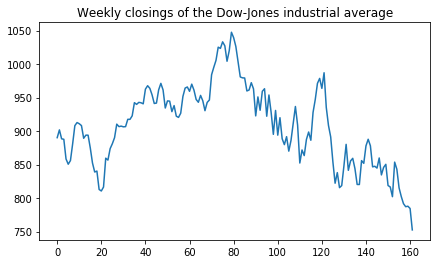

In [38]:
series = dowjones_closing["Close"]


plt.figure(figsize=(7, 4))
plt.plot(series)
plt.title('Weekly closings of the Dow-Jones industrial average')
plt.show()

In [4]:
#Скопируем функции из прошлых занятий для оценки временного ряда 
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [5]:
# Поделим наш ВР на тренировочную и тестовую выборки
train = series[:130]
test = series[130:]

aic: 1124.58908 | order: (4, 2, 3)
Results of Dickey-Fuller Test:
Test Statistic                -1.104921e+01
p-value                        5.130345e-20
#Lags Used                     0.000000e+00
Number of Observations Used    1.270000e+02
Critical Value (1%)           -3.482920e+00
Critical Value (5%)           -2.884580e+00
Critical Value (10%)          -2.579058e+00
dtype: float64


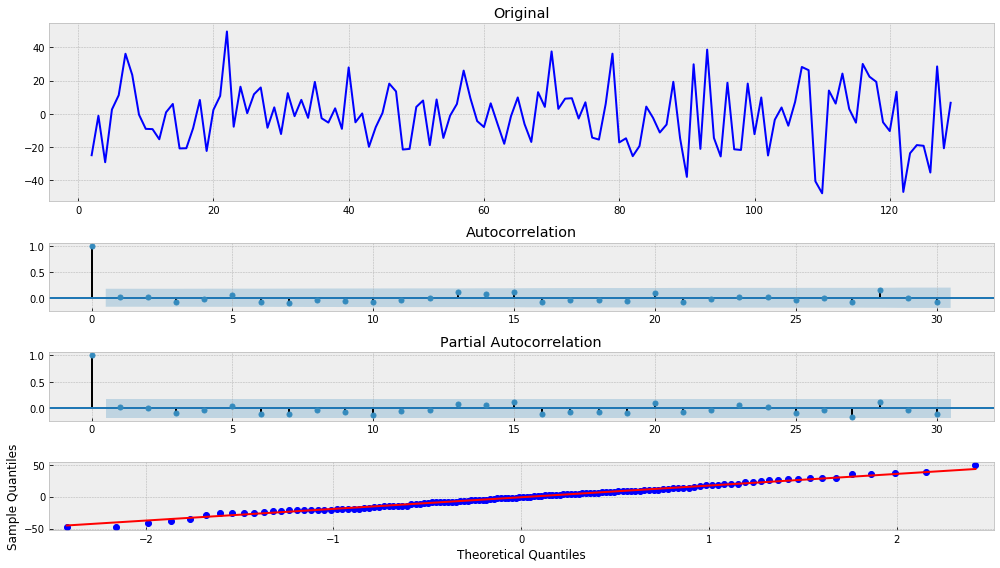

In [6]:
# Подберем оптимальные параметры с минимальными AIC

import warnings
warnings.filterwarnings("ignore")

best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(train, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

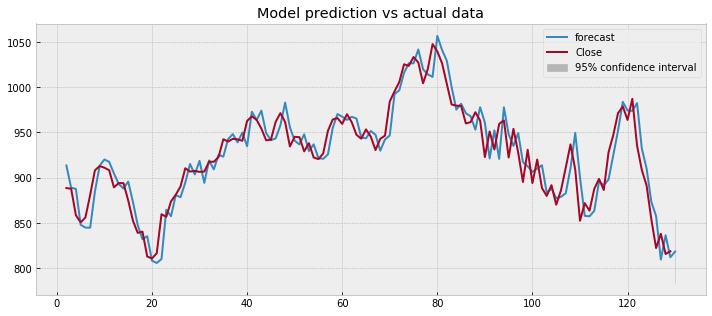

In [78]:
# Отобразим графически актуальные значения тренировочной выборки и то, что нам нарисует получившаяся модель

with plt.style.context('bmh'):
    plt.figure(figsize=(12,5))
    ax = plt.axes()
    best_mdl.plot_predict(2, len(train), ax=ax)
    plt.title('Model prediction vs actual data')
    plt.legend()
    plt.show()

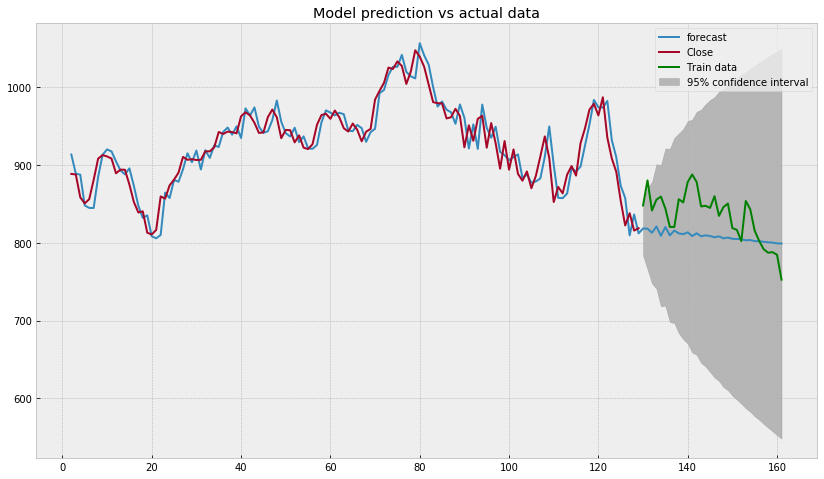

In [77]:
# Посмотрим, что нам спрогназирует модель и как сильно ее прогноз будет отличаться от данных в тестовой выборке

with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(2, len(train)+31, ax=ax)
    plt.plot(test, color='green', label='Train data')
    plt.title('Model prediction vs actual data')
    plt.legend()
    plt.show()

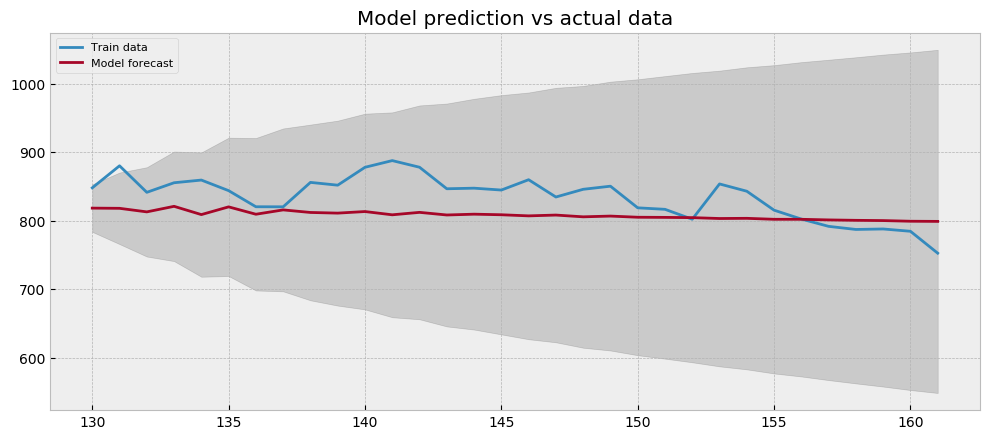

In [80]:
# Приблизим прогнозные значения и аткуальные тестовые данные

with plt.style.context('bmh'):
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(test, label='Train data')
    plt.plot(fc_series, label='Model forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('Model prediction vs actual data')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()